Training Actor-Critic...
Episode 0: Average Reward = -100.00
Episode 10: Average Reward = -28.70
Episode 20: Average Reward = 40.50
Episode 30: Average Reward = 4.30
Episode 40: Average Reward = -25.90
Episode 50: Average Reward = -81.10
Episode 60: Average Reward = -16.40
Episode 70: Average Reward = 13.40
Episode 80: Average Reward = -86.40
Episode 90: Average Reward = -74.50
Episode 100: Average Reward = -82.70
Episode 110: Average Reward = -80.70
Episode 120: Average Reward = -100.00
Episode 130: Average Reward = -81.20
Episode 140: Average Reward = -80.90
Episode 150: Average Reward = -62.10
Episode 160: Average Reward = -28.40
Episode 170: Average Reward = -46.80
Episode 180: Average Reward = -30.40
Episode 190: Average Reward = -39.70
Episode 200: Average Reward = -49.20
Episode 210: Average Reward = -100.00
Episode 220: Average Reward = -80.10
Episode 230: Average Reward = -80.00
Episode 240: Average Reward = -75.40
Episode 250: Average Reward = -14.50
Episode 260: Average Rewa

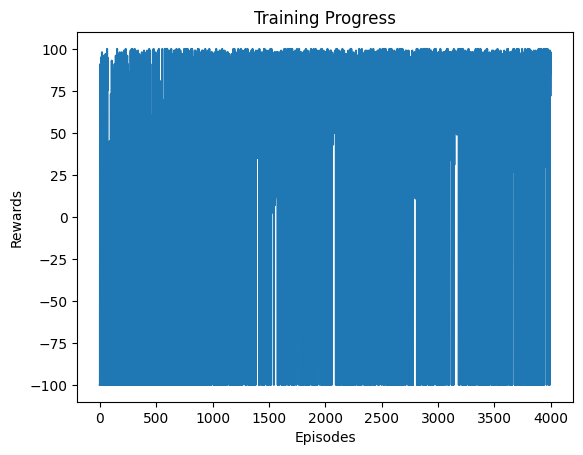

Generating and displaying learned policy...


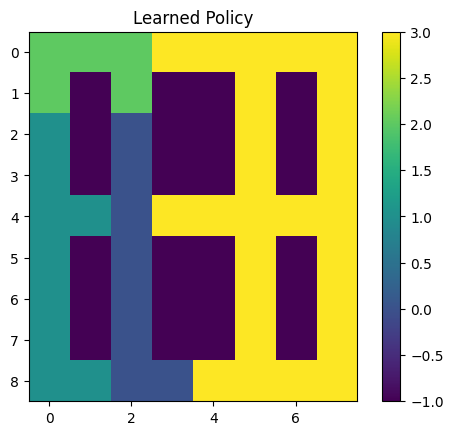

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from itertools import product

# Warehouse Agent
class warehouse_agent:
    def __init__(self, rows, columns):
        # Actions: ['Up' 0, 'Right' 1, 'Down' 2, 'Left' 3]
        self.A = np.array([0, 1, 2, 3])
        # Transition function probabilities
        self.P = np.array([0.95, 0.97, 0.99, 1.0])  # Reduced stochasticity
        self.rows = rows
        self.columns = columns
        self.reward = None
        self.terminal_states = None
        self.H = None  # environment height
        self.W = None  # environment width
        self._generate_environment(rows, columns)

    def _generate_environment(self, rows, columns):
        # Initialize the grid environment
        self.H = 3 * rows + rows + 1
        self.W = 3 * columns + 2
        reward = -np.ones((self.H, self.W))
        reward[:, np.arange(1, self.W - 3, 3)] = -9  # Aisle separators
        reward[:, np.arange(3, self.W, 3)] = -9
        reward[np.arange(0, self.H, 4)] = -1  # Row separators
        reward[2, 2] = 100  # Set terminal state reward
        self.reward = reward

        # Terminal states at specific locations
        self.terminal_states = np.array([[2, 2]])

    def generate_ini_state(self, terminate_x, terminate_y):
        # Generate a random initial state that's not the terminal state
        while True:
            x = np.random.randint(0, self.H)
            y = np.random.randint(0, self.W)
            if (x, y) != (terminate_x, terminate_y) and self.reward[x, y] != -9:
                return [x, y]

    def apply_transition_function(self, intended_action):
        c = np.random.rand()
        if c < self.P[0]:  # Move in the intended direction
            return intended_action
        elif c < self.P[1]:  # Turn left
            return (intended_action - 1) % len(self.A)
        elif c < self.P[2]:  # Turn right
            return (intended_action + 1) % len(self.A)
        else:  # No action
            return None

    def computeNextPosition(self, row, col, action):
        if action is None:  # No action, stay in the same position
            return int(row), int(col)

        new_row, new_col = int(row), int(col)
        if action == 0:  # Up
            new_row -= 1
        elif action == 1:  # Right
            new_col += 1
        elif action == 2:  # Down
            new_row += 1
        elif action == 3:  # Left
            new_col -= 1

        # Check boundaries and walls
        if (
            new_row < 0
            or new_row >= self.H
            or new_col < 0
            or new_col >= self.W
            or self.reward[new_row, new_col] == -9
        ):
            return int(row), int(col)  # Stay in the same position if invalid move
        return int(new_row), int(new_col)

    def present_policy(self, policy):
        grid_policy = np.full((self.H, self.W), -1, dtype=float)
        for i in range(self.H):
            for j in range(self.W):
                if self.reward[i, j] != -9:
                    grid_policy[i, j] = policy[i, j]
        return grid_policy

    def display_policy(self, policy):
        grid_policy = self.present_policy(policy)
        plt.imshow(grid_policy, cmap="viridis", interpolation="nearest")
        plt.colorbar()
        plt.title("Learned Policy")
        plt.show()


# Actor-Critic Model
class ActorCriticModel(tf.keras.Model):
    def __init__(self, num_actions):
        super(ActorCriticModel, self).__init__()
        self.common = layers.Dense(128, activation="relu")
        self.actor = layers.Dense(num_actions, activation="softmax")
        self.critic = layers.Dense(1)

    def call(self, inputs):
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

# Training Function
def train_actor_critic(agent, model, episodes=500, gamma=0.94, learning_rate=0.0004, max_steps=100):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    total_rewards = []

    for episode in range(episodes):
        # Reset environment
        start_state = agent.generate_ini_state(agent.terminal_states[0][0], agent.terminal_states[0][1])
        state = np.array(start_state, dtype=np.float32)
        state = np.expand_dims(state, axis=0)

        episode_reward = 0
        done = False
        steps = 0

        while not done and steps < max_steps:
            steps += 1
            with tf.GradientTape() as tape:
                action_probs, state_value = model(state)

                # Choose action
                action = np.random.choice(len(agent.A), p=np.squeeze(action_probs))

                # Simulate environment step
                real_action = agent.apply_transition_function(action)
                next_state = agent.computeNextPosition(state[0, 0], state[0, 1], real_action)
                reward = agent.reward[next_state[0], next_state[1]]
                done = (np.array(next_state) == agent.terminal_states[0]).all()

                next_state = np.array(next_state, dtype=np.float32)
                next_state = np.expand_dims(next_state, axis=0)

                _, next_state_value = model(next_state)
                target = reward + gamma * next_state_value * (1 - int(done))
                td_error = target - state_value

                actor_loss = -tf.math.log(action_probs[0, action]) * td_error
                critic_loss = tf.square(td_error)
                loss = actor_loss + critic_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)
        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards[-10:])
            print(f"Episode {episode}: Average Reward = {avg_reward:.2f}")

    return total_rewards

# Generate Learned Policy
def generate_learned_policy(agent, model):
    policy = np.zeros((agent.H, agent.W))
    for i in range(agent.H):
        for j in range(agent.W):
            if agent.reward[i, j] != -9:
                state = np.array([[i, j]], dtype=np.float32)
                action_probs, _ = model(state)
                policy[i, j] = np.argmax(action_probs)
    return policy

# Testing Function
def test_policy(agent, model):
    start_state = agent.generate_ini_state(agent.terminal_states[0][0], agent.terminal_states[0][1])
    state = np.array(start_state, dtype=np.float32)
    state = np.expand_dims(state, axis=0)
    done = False
    total_reward = 0

    while not done:
        action_probs, _ = model(state)
        action = np.argmax(action_probs)

        real_action = agent.apply_transition_function(action)
        next_state = agent.computeNextPosition(state[0, 0], state[0, 1], real_action)
        reward = agent.reward[next_state[0], next_state[1]]
        done = (np.array(next_state) == agent.terminal_states[0]).all()

        total_reward += reward
        state = np.expand_dims(np.array(next_state, dtype=np.float32), axis=0)
        print(f"State: {next_state}, Reward: {reward}")

    print(f"Total Test Reward: {total_reward}")
    return total_reward

# Plot Rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Training Progress')
    plt.show()

# Main Script
if __name__ == "__main__":
    # Initialize warehouse agent
    agent = warehouse_agent(rows=2, columns=2)  # Set up a 2x2 aisle environment

    num_actions = len(agent.A)
    model = ActorCriticModel(num_actions)

    print("Training Actor-Critic...")
    rewards = train_actor_critic(agent, model, episodes=4000)

    print("Testing the learned policy...")
    test_policy(agent, model)
    plot_rewards(rewards)

    print("Generating and displaying learned policy...")
    policy = generate_learned_policy(agent, model)
    agent.display_policy(policy)
